In [ ]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

In [ ]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW9


---
__Name:__  *Your Name Goes Here*   
__Class:__ MIDS w261 (Section *Your Section Goes Here*, e.g., Fall 2016 Group 1)     
__Email:__  *Your UC Berkeley Email Goes Here*@iSchool.Berkeley.edu     
__Unit 9:__   

__Due Time:__ HW9 is due on FRIDAY 11/11/2016. 


# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW  Problems](#3)   
    1.0.  [HW9.0](#1.0)   
    1.0.  [HW9.1](#1.1)   
    1.2.  [HW9.2](#1.2)   
    1.3.  [HW9.3](#1.3)    
    1.4.  [HW9.4](#1.4)    
    1.5.  [HW9.5](#1.5)    
    1.5.  [HW9.6](#1.6)    
   

<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #9

Version 2016-11-01 

### INSTRUCTIONS for SUBMISSIONS
Please use the following form for HW submission:

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


### IMPORTANT

HW9 can be completed locally on your computer for most part but will require a cluster of computers for the bigger wikipedia dataset.

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week
* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 



<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<h2 style="color:darkblue">HW 9 Dataset</h2>

Note that all referenced files life in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

## 3.  HW9.0  Short answer questions<a name="1.0"></a>
[Back to Table of Contents](#TOC)

__ What is PageRank and what is it used for in the context of web search?__



<hr>

__ What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution? __



<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __



<hr>


## 3.  HW9.1  MRJob implementation of basic PageRank <a name="1.1"></a>
[Back to Table of Contents](#TOC)

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]


As you build your code, use the test data:

> s3://ucb-mids-mls-networks/PageRank-test.txt

Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

In [160]:
%%writefile prEDA.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import itertools

class EDA(MRJob):
    
    def configure_options(self):
        super(EDA, self).configure_options()
        self.add_passthrough_option('--feature', type = "str")
        
    def __init__(self, *args, **kwargs):
        super(EDA, self).__init__(*args, **kwargs)
        self.feature = self.options.feature
        self.nodes = set()
        self.frequency = 0 
        self.numLinks = 0
        self.minDegree = 0
        self.maxDegree = 0 
        self.options.jobconf = {"mapred.reduce.tasks":1 }
        
    def mapper(self, key, line):
        node, neighbors = line.strip().split("\t")
        neighbors = ast.literal_eval(neighbors)
        numLinks = len(neighbors)
        self.nodes.add(node)
        for neighbor in neighbors:
            self.nodes.add(neighbor)

        if self.feature == "Nodes" or self.feature == "numNodes":
            for neighbor in neighbors:
                yield neighbor, 1
            yield node, 1
        elif self.feature == "numLinks":
            yield node, numLinks
        elif self.feature == "averageDegree":
            yield node, numLinks
        elif self.feature == "minMaxDegree":
            yield None, numLinks
        else:
            print "Acceptable features: numNodes, numLinks, averageDegree, minMaxDegree"
            exit()
            
    def combiner(self, key, values):
        if self.feature == "Nodes" or self.feature == "numNodes":
            yield key, 1
        elif self.feature == "numLinks":
            yield key, sum(values)
        elif self.feature == "averageDegree":
            yield key, sum(values)
        elif self.feature == "minMaxDegree":
            values, valuesCp = itertools.tee(values)
            yield None, (min(values), max(valuesCp))
        
    def reducer(self, key, values):
        if self.feature == "Nodes" or self.feature == "numNodes":
            self.frequency+=1
            self.nodes.add(key)
        elif self.feature == "numLinks":
            self.numLinks += sum(values)
        elif self.feature == "averageDegree":  
            self.frequency+=1
            self.numLinks += sum(values)
        elif self.feature == "minMaxDegree":
            values, valuesCp = itertools.tee(values)
            self.maxDegree = max(values)
            self.minDegree = min(valuesCp)
    
    def reducer_final(self):
        if self.feature == "numNodes":
            yield "Number of Nodes: ", self.frequency
        elif self.feature == "numLinks":
            yield "Number of Links", self.numLinks
        elif self.feature == "averageDegree":
            yield "Average Degree: ", float(self.numLinks)/self.frequency
        elif self.feature == "minMaxDegree":
            yield "Min/Max Degree: ", (self.minDegree, self.maxDegree)
        elif self.feature == "Nodes":
            yield "", [node for node in self.nodes]
        
    
    def steps(self):
        return [MRStep(mapper=self.mapper,reducer=self.reducer,
                      reducer_final=self.reducer_final)] 
    
if __name__ == '__main__':
    EDA.run()

Overwriting prEDA.py


In [162]:
!./prEDA.py PageRank-test.txt --feature "numNodes" 
!./prEDA.py PageRank-test.txt --feature "Nodes" --output "testNodes"
!./prEDA.py PageRank-test.txt --feature "numLinks" 
!./prEDA.py PageRank-test.txt --feature "averageDegree" 
!./prEDA.py PageRank-test.txt --feature "minMaxDegree" 


No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/prEDA.AnthonySpalvieriKruse.20161110.225712.209624
Running step 1 of 1...
Streaming final output from /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/prEDA.AnthonySpalvieriKruse.20161110.225712.209624/output...
"Number of Nodes: "	11
Removing temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/prEDA.AnthonySpalvieriKruse.20161110.225712.209624...
No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/prEDA.AnthonySpalvieriKruse.20161110.225712.505661
Streaming final output from testNodes.txt...
""	["A", "C", "B", "E", "D", "G", "F", "I", "H", "K", "J"]
Removing temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/prEDA.AnthonySpalvieriKruse.20161110.225712.505661...
No configs found; falling back on auto-configuration
Creating temp directory /var

<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

In [410]:
%%writefile PageRankAlternate.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

##!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict
import ast

class PageRankAlternate(MRJob):
        
    def configure_options(self):
        super(PageRankAlternate, self).configure_options()
        self.add_passthrough_option('--iterations', type = "int", default=1)
        self.add_passthrough_option('--N', type = "int", default = -1)
        self.add_passthrough_option('--alpha', type = "float", default = .15)
    
    def __init__(self, *args, **kwargs):
        super(PageRankAlternate, self).__init__(*args, **kwargs)
        self.iterations = self.options.iterations
        self.N = self.options.N
        self.alpha = self.options.alpha
        self.loss = 0
        self.inflator = 10**12
        self.options.jobconf = {"mapred.reduce.tasks":1 }

        
    def initialize_graph_map(self, _, line):
        node, links = line.strip().split("\t")
        links = ast.literal_eval(links)
        for link in links:
            yield link, {}
        yield node, links
        
    def initialize_graph_combine(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        yield node, links
    
    def initialize_graph_reduce(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        yield node, (links, float(1)/self.N)
        
    #Because lines are unique, each node here will occur only once 
    #If it's got links, it's not dangling, and we have 0 for dangling cell
    #if it lacks links, it is dangling, so we add it's nodeProb to dangling
    def pass_mass(self, node, line):
        links, prob = line
        #Gets called on the first iteration
        if isinstance(links, basestring):
            links = ast.literal_eval(links)
        
        numLinks = len(links)
        if numLinks == 0:
            self.loss += prob * self.inflator
            #Format: yield node, (links, passedMass, danglingLossMass)
            yield node, (links, 0)
        else:
            for link in links:
                yield link, ({}, float(prob)/numLinks)
            yield node, (links, 0)
    
    def mapper_final(self):
        yield "0", (self.loss)
    
    def combiner(self, node, lines):
        if node == "0":
            loss = sum(lines)
            yield node, loss
        else:
            nodeProb = 0
            links = {}
            for item in lines:
                link, passedMass = item 
                nodeProb+=passedMass
                if len(link)!=0:
                    links = link
            yield node, (links, nodeProb)
        
    def sum_mass(self, node, lines): 
        if node == "0":
            self.loss = sum(lines)
        else:
            loss = float(self.loss)/self.inflator
            total=0
            links = {}
            G = self.N
            a = self.alpha
            for item in lines:
                link, prob = item
                total+=prob
                if len(link) != 0:
                    links = link

            updatedProb = float(a)/G + (1-a)*(float(loss)/G + total) 
            yield node, (links, updatedProb)
            
    def steps(self):
        return (
                [MRStep(mapper=self.initialize_graph_map, 
                        combiner = self.initialize_graph_combine,
                        reducer = self.initialize_graph_reduce)] +
                [MRStep(mapper = self.pass_mass, mapper_final = self.mapper_final,
                        combiner=self.combiner,
                        reducer = self.sum_mass)] * self.options.iterations
        )
    
if __name__ == '__main__':
    PageRankAlternate.run()

Overwriting PageRankAlternate.py


In [413]:
!./PageRankAlternate.py PageRank-test_indexed.txt --iterations 15 --N 11 --alpha .15

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankAlternate.AnthonySpalvieriKruse.20161113.174122.245354
Running step 1 of 16...
Running step 2 of 16...
Running step 3 of 16...
Running step 4 of 16...
Running step 5 of 16...
Running step 6 of 16...
Running step 7 of 16...
Running step 8 of 16...
Running step 9 of 16...
Running step 10 of 16...
Running step 11 of 16...
Running step 12 of 16...
Running step 13 of 16...
Running step 14 of 16...
Running step 15 of 16...
Running step 16 of 16...
Streaming final output from /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankAlternate.AnthonySpalvieriKruse.20161113.174122.245354/output...
"1"	[{}, 0.032792273760929885]
"10"	[{"5": 1}, 0.01617057945713026]
"11"	[{"5": 1}, 0.01617057945713026]
"2"	[{"3": 1}, 0.39358416178217803]
"3"	[{"2": 1}, 0.3336748502065788]
"4"	[{"1": 1, "2": 1}, 0.03909527553272476]
"5"	[{"2": 1, "4": 1, "6": 1}, 0.08090526589921213

In [292]:
%%writefile PageRank.py
#!/usr/bin/env python
##!/Users/AnthonySpalvieriKruse/anaconda/bin/python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class PageRank(MRJob):

    def configure_options(self):
        super(PageRank, self).configure_options()
        self.add_passthrough_option('--iterations', type = "int", default=1)
        self.add_passthrough_option('--N', type = "int", default = -1)
        self.add_passthrough_option('--alpha', type = "float", default = .15)
    
    def __init__(self, *args, **kwargs):
        super(PageRank, self).__init__(*args, **kwargs)
        self.iterations = self.options.iterations
        self.N = self.options.N
        self.alpha = self.options.alpha
    
    def initialize_graph(self, _, line):
        node, links = line.strip().split("\t")
        yield node, (links, float(1)/self.N)
        
    def pass_mass(self, node, line):
        links, prob = line
        
        #Gets called on the first iteration
        if isinstance(links, basestring):
            links = ast.literal_eval(links)
        
        numLinks = len(links)
        if numLinks == 0:
            yield "dangling", prob
        else:
            for link in links:
                yield link, prob/numLinks

        yield node, links
    
    def combiner(self, node, lines):
        if node == "dangling":
            yield node, sum(lines)
        else:
            total = 0 
            links = {}
            for item in lines:
                if type(item) is float:
                    total+=item
                else:
                    links = item
                    yield node, links
            yield node, total
        
    def sum_mass(self, node, lines): 
        if node == "dangling":
            loss = sum(lines)
            #This assumes the nodes are indexed, which could fail
            #Better idea is to pass file w/ all nodes, and iterate through this list
            for i in range(1, int(self.options.N) + 1):
                yield str(i), loss
        else:
            total = 0 
            links = {}
            for item in lines:
                if type(item) is float:
                    total+=item
                else:
                    links = item
            yield node, (links, total)
    
    def teleport(self, node, lines):
        G = self.N
        a = self.alpha
        loss = 0
        
        for item in lines:
            if type(item) == float:
                loss = item
            else:
                links, prob = item
            
        updatedProb = float(a)/G + (1-a)*(float(loss)/G + prob) 
        yield node, (links, updatedProb)
    
    def steps(self):
        return (
                [MRStep(mapper=self.initialize_graph)] +
                [MRStep(mapper = self.pass_mass, combiner=self.combiner, reducer = self.sum_mass),
                 MRStep(reducer = self.teleport)] * self.options.iterations
        )
    
if __name__ == '__main__':
    PageRank.run()

Overwriting PageRank.py


In [707]:
%%writefile PageRankPreprocess.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

##!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict
import ast

class PageRankPreprocess(MRJob):
        
    def configure_options(self):
        super(PageRankPreprocess, self).configure_options()
        self.add_passthrough_option('--N', type = "int", default = -1)
    
    def __init__(self, *args, **kwargs):
        super(PageRankPreprocess, self).__init__(*args, **kwargs)
        self.N = self.options.N
        self.inflator = 10**12
        
    def initialize_graph_map(self, _, line):
        node, links = line.strip().split("\t")
        links = ast.literal_eval(links)
        for link in links:
            yield link, {}
        yield node, links
        
    def initialize_graph_combine(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        yield node, links
    
    def initialize_graph_reduce(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        #if dangling increment loss counter
        if len(links) == 0:
            self.increment_counter('loss', 'lossCounter', int(self.inflator*float(1)/self.N))

        yield node, (links, float(1)/self.N)
            
    def steps(self):
        return (
                [MRStep(mapper=self.initialize_graph_map, 
                        combiner = self.initialize_graph_combine,
                        reducer = self.initialize_graph_reduce)] 
        )
    
if __name__ == '__main__':
    PageRankPreprocess.run()

Overwriting PageRankPreprocess.py


In [706]:
%%writefile PageRankScale.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

##!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict
import ast

class PageRankScale(MRJob):
        
    def configure_options(self):
        super(PageRankScale, self).configure_options()
        self.add_passthrough_option('--N', type = "int", default = -1)
        self.add_passthrough_option('--alpha', type = "float", default = .15)
        self.add_passthrough_option('--loss', type = "float", default = 0)
    
    def __init__(self, *args, **kwargs):
        super(PageRankScale, self).__init__(*args, **kwargs)
        self.N = self.options.N
        self.alpha = self.options.alpha
        self.inflator = 10**12
        self.loss = float(self.options.loss)/self.inflator

    def pass_mass(self, node, line):
        node, linksAndProb = map(lambda x: ast.literal_eval(x), line.split('\t'))
        links, prob = linksAndProb
        if isinstance(links, basestring):
            links = ast.literal_eval(links)
            
        numLinks = len(links)
        for link in links:
            yield link, ({}, float(prob)/numLinks)
        yield node, (links, 0)
    
    
    def combiner(self, node, lines):
        nodeProb = 0
        links = {}
        for item in lines:
            link, passedMass = item 
            nodeProb+=passedMass
            if len(link)!=0:
                links = link
        yield node, (links, nodeProb)
        
    def sum_mass(self, node, lines): 
        total=0
        links = {}
        G = self.N
        a = self.alpha
        for item in lines:
            link, prob = item
            total+=prob
            if len(link) != 0:
                links = link

        updatedProb = float(a)/G + (1-a)*(float(self.loss)/G + total) 
        
        if len(links) == 0:
            self.increment_counter('loss', 'lossCounter', int(self.inflator*updatedProb))

        yield node, (links, updatedProb)
            
    def steps(self):
        return (
            [MRStep(mapper = self.pass_mass,
                        combiner=self.combiner,
                        reducer = self.sum_mass)]
        )
    
if __name__ == '__main__':
    PageRankScale.run()

Overwriting PageRankScale.py


In [702]:
!./PageRankPreprocess.py PageRank-test_indexed.txt --N 11 > graphPreprocessed.txt

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankPreprocess.AnthonySpalvieriKruse.20161115.013205.489336
Running step 1 of 1...
Counters: 1
	loss
		lossCounter=909090909
Streaming final output from /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankPreprocess.AnthonySpalvieriKruse.20161115.013205.489336/output...
Removing temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankPreprocess.AnthonySpalvieriKruse.20161115.013205.489336...


In [710]:
%%writefile PageRankRunnerScale.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

from numpy import random,array
from PageRankScale import PageRankScale
from PageRankPreprocess import PageRankPreprocess
import sys 

#Plan: Preprocess -> run -> get counter -> 

numIterations = sys.argv[2]
#Don't forget to add -r hadoop
mr_job = PageRankPreprocess(args=[sys.argv[1], "--output-dir", "preprocessed0/", "--N", "11"])
i=0
print numIterations
for i in range(0,int(numIterations)):
    print "iteration: ", i
    
    with mr_job.make_runner() as runner: 
        runner.run()
        lossMap = runner.counters()
        loss = lossMap[0]["loss"]["lossCounter"]
        print loss
    
    #Don't forget to add -r hadoop
    mr_job = PageRankScale(args=['preprocessed'+str(i)+'/', "--N", "11", "--alpha", ".15", "--loss", str(loss), "--output-dir", "preprocessed"+str(i+1)+"/"])
        
    i += 1
    

Writing PageRankRunnerScale.py


In [711]:
!./PageRankRunnerScale.py PageRank-test_indexed.txt 20

/bin/sh: ./PageRankRunnerScale.py: Permission denied


In [297]:
!./PageRankAlternate.py PageRank-test_indexed.txt --iterations 1 --N 11 --alpha .15

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankAlternate.AnthonySpalvieriKruse.20161113.000233.295345
Running step 1 of 3...
Running step 2 of 3...
Running step 3 of 3...
Streaming final output from /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankAlternate.AnthonySpalvieriKruse.20161113.000233.295345/output...
"1"	[{}, 0.05227272727272727, 0]
"10"	[{"5": 1}, 0.013636363636363636, 0]
"11"	[{"5": 1}, 0.013636363636363636, 0]
"2"	[{"3": 1}, 0.3098484848484848, 0]
"3"	[{"2": 1}, 0.09090909090909091, 0]
"4"	[{"1": 1, "2": 1}, 0.03939393939393939, 0]
"5"	[{"2": 1, "4": 1, "6": 1}, 0.3227272727272727, 0]
"6"	[{"2": 1, "5": 1}, 0.03939393939393939, 0]
"7"	[{"2": 1, "5": 1}, 0.013636363636363636, 0]
"8"	[{"2": 1, "5": 1}, 0.013636363636363636, 0]
"9"	[{"2": 1, "5": 1}, 0.013636363636363636, 0]
Removing temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankAlternate.AnthonySpalvieriK

In [356]:
!./PageRank.py PageRank-test_indexed.txt --iterations 15 --N 11 --alpha .15
## Drivers & Runners

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRank.AnthonySpalvieriKruse.20161113.020616.972685
Running step 1 of 31...
Running step 2 of 31...
Running step 3 of 31...
Running step 4 of 31...
Running step 5 of 31...
Running step 6 of 31...
Running step 7 of 31...
Running step 8 of 31...
Running step 9 of 31...
Running step 10 of 31...
Running step 11 of 31...
Running step 12 of 31...
Running step 13 of 31...
Running step 14 of 31...
Running step 15 of 31...
Running step 16 of 31...
Running step 17 of 31...
Running step 18 of 31...
Running step 19 of 31...
Running step 20 of 31...
Running step 21 of 31...
Running step 22 of 31...
Running step 23 of 31...
Running step 24 of 31...
Running step 25 of 31...
Running step 26 of 31...
Running step 27 of 31...
Running step 28 of 31...
Running step 29 of 31...
Running step 30 of 31...
Running step 31 of 31...
Streaming final output from /var/folders/tl/kz2xr4bd3d

In [2]:
%%writefile PageRankRunner.py
#!/usr/bin/env python
##!/Users/AnthonySpalvieriKruse/anaconda/bin/python

from numpy import random,array
from PageRank import PageRank
import sys 

def runPageRank(alpha, output):
    mr_job = PageRank(args=["PageRank-test_indexed.txt", "-r", "hadoop", "--iterations", "12", "--N",
                            "11", "--alpha", alpha, "--output", output])
    visited = set()
    firstPass = True

    with mr_job.make_runner() as runner: 
            runner.run()

    # stream_output: get access of the output 
    for line in runner.stream_output():
        # value is the gradient value
        node, value =  mr_job.parse_output_line(line)
        print node, value

if __name__ == "__main__":
    runPageRank(sys.argv[1], sys.argv[2])


Overwriting PageRankRunner.py


<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>




<br><br>

## 3.  HW9.2: Exploring PageRank teleportation and network plots <a name="1.2"></a>
[Back to Table of Contents](#TOC)


* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

In [128]:
import PageRankRunner as prr

alphas = [0,0.25,0.5,0.75, 0.85, 1]

for alpha in alphas:
    prr.runPageRank(alpha, "output/graph_{}".format(alpha))

1 [{}, 0.000520591833482673]
10 [{u'5': 1}, 0.00010558523000447849]
11 [{u'5': 1}, 0.00010558523000447849]
2 [{u'3': 1}, 0.38400157742994956]
3 [{u'2': 1}, 0.6124293358239826]
4 [{u'1': 1, u'2': 1}, 0.0008050824482794051]
5 [{u'2': 1, u'4': 1, u'6': 1}, 0.0009104038660036321]
6 [{u'2': 1, u'5': 1}, 0.0008050824482794051]
7 [{u'2': 1, u'5': 1}, 0.00010558523000447849]
8 [{u'2': 1, u'5': 1}, 0.00010558523000447849]
9 [{u'2': 1, u'5': 1}, 0.00010558523000447849]
1 [{}, 0.04630914414862571]
10 [{u'5': 1}, 0.02588609844107977]
11 [{u'5': 1}, 0.02588609844107977]
2 [{u'3': 1}, 0.32558170861680436]
3 [{u'2': 1}, 0.27549669005271776]
4 [{u'1': 1, u'2': 1}, 0.05446066550463443]
5 [{u'2': 1, u'4': 1, u'6': 1}, 0.11426063396718444]
6 [{u'2': 1, u'5': 1}, 0.05446066550463443]
7 [{u'2': 1, u'5': 1}, 0.02588609844107977]
8 [{u'2': 1, u'5': 1}, 0.02588609844107977]
9 [{u'2': 1, u'5': 1}, 0.02588609844107977]
1 [{}, 0.06694783807417107]
10 [{u'5': 1}, 0.04849763611502909]
11 [{u'5': 1}, 0.048497636115

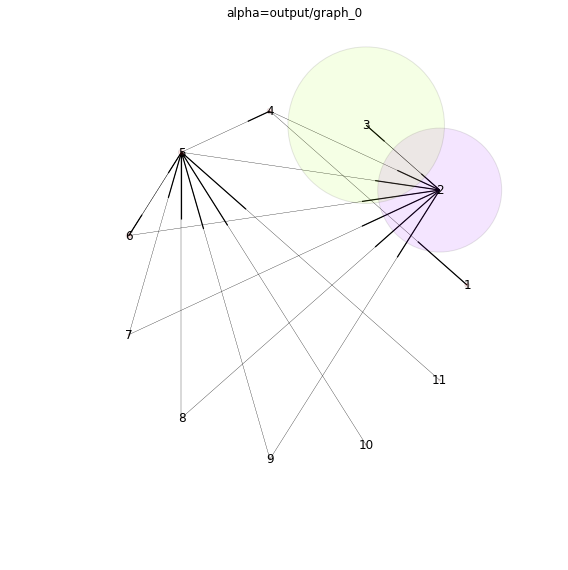

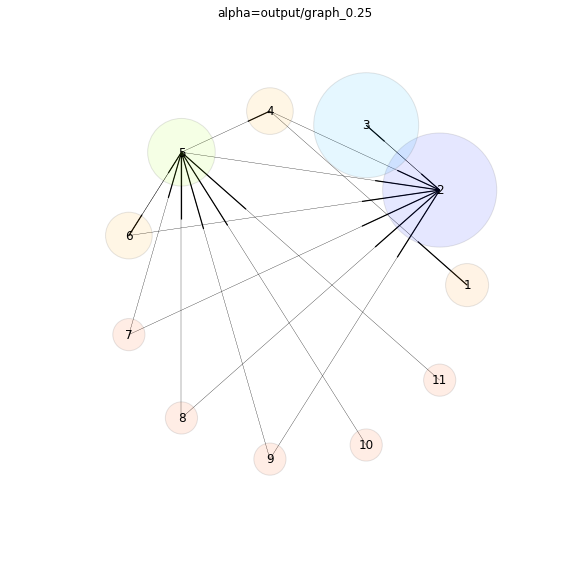

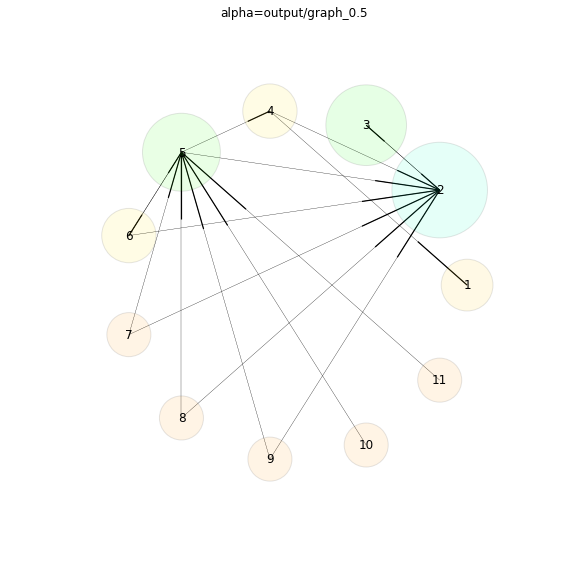

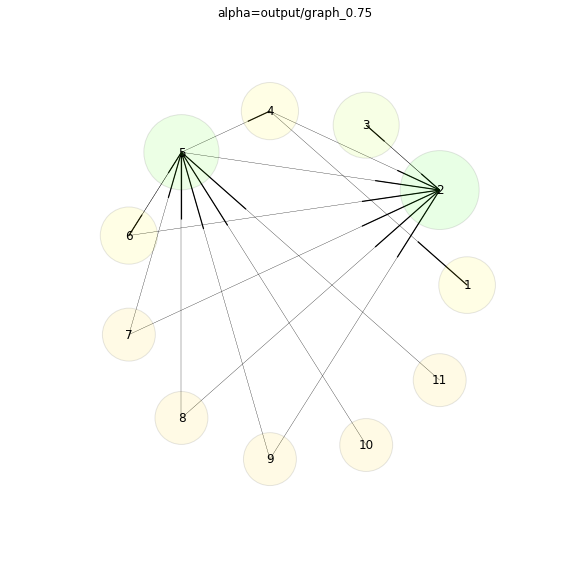

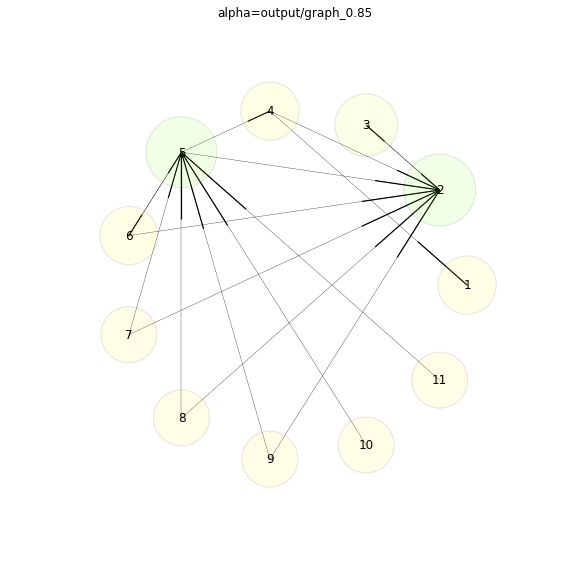

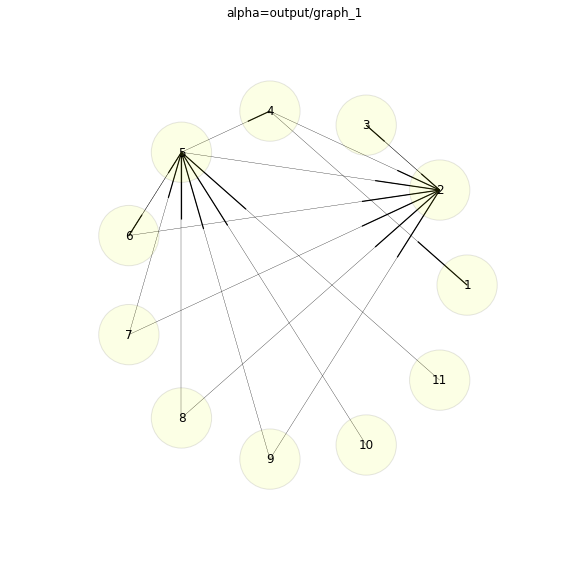

In [209]:
%matplotlib inline

import networkx as nx
import ast
from matplotlib import pyplot as plt
import os
import colorsys

    
def draw_graph(path):
    plt.figure(figsize=(8, 8))
    probs = {}
    graph = nx.DiGraph()
    
    for fname in os.listdir(path):
        with open(path+"/"+fname) as f:
            for line in f:
                node, linksAndProb = line.strip().split("\t")
                node = node.replace('"','')
                links, prob = ast.literal_eval(linksAndProb)
                probs[int(node)] = prob
                
                for link in links:
                    graph.add_edge(int(node), int(link))

    weights = [probs[n]*40000 for n in graph.nodes()]
    layout = nx.circular_layout(graph)
    
    # set labels and colors
    labels = {n:n for n in graph.nodes()}
    
    HSV_tuples = [(x*2, 1, 1) for x in probs.values()]
    node_colors = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)

    # draw graph
    nx.draw_networkx_nodes(graph, layout, node_size = weights, alpha = 0.1, node_color = node_colors)
    nx.draw_networkx_edges(graph, layout, width = 0.3, alpha = 1, edge_color = 'black')
    nx.draw_networkx_labels(graph, layout, labels=labels, font_size = 12)
    # show graph
    plt.title("alpha={}".format(path))
    plt.axis('off')
    plt.tight_layout()
    plt.show()
            
    
for path in os.listdir("output"):
    draw_graph("output/"+path)
                
                


<h2 style="color:darkgreen">  HW 9.2 Analysis </h2>




<br><br>

## 3.  HW9.3: Applying PageRank to the Wikipedia hyperlinks network <a name="1.3"></a>
[Back to Table of Contents](#TOC)

<
* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

In [2]:
#god willing my large run will finish on altiscale and i can copy paste the results over here
#in the morning 

In [3]:
## Run Scripts, S3 Sync

In [ ]:
%%writefile Sort.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import bisect
import itertools
import re

class Sort(MRJob):

    def configure_options(self):
        super(Sort, self).configure_options()
        self.add_passthrough_option('--N', type = "int", default = 100)
    
    def __init__(self, *args, **kwargs):
        super(Sort, self).__init__(*args, **kwargs)
        self.options.jobconf = {"mapred.reduce.tasks":1 , 
                                'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.comparator.options': '-k1r'}
        self.N = self.options.N
        self.nodes = ["nada" for i in range(self.N)]
        self.topN = [0 for i in range(self.N)]
    
    def mapper(self, node, line):
        key, value = line.strip().split("\t")
        key = key.replace('"','')
        links, prob = ast.literal_eval(value)
        
        yield prob, key
        
    def reducer(self, node, lines): 
        if node > self.topN[0]:
            insertionIndex = bisect.bisect(self.topN,node)
            self.nodes.insert(insertionIndex, next(lines))
            self.topN.insert(insertionIndex, node)
            del self.nodes[0]
            del self.topN[0]
        
    def reducer_final(self):
        self.topN.reverse()
        self.nodes.reverse()
        for i in range(self.N):
            yield self.nodes[i] , self.topN[i]
    
    def steps(self):
        return (
                [MRStep(mapper = self.mapper, reducer = self.reducer, reducer_final = self.reducer_final)] 
        )
    
if __name__ == '__main__':
    Sort.run()

 <h2 style="color:darkgreen">  HW 9.3 Analysis </h2>




<br><br>

## 3.  HW9.4: Topic-specific PageRank implementation using MRJob <a name="1.4"></a>
[Back to Table of Contents](#TOC)

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

In [420]:
from collections import defaultdict
import json

topicCounts = defaultdict(int)
f = open("randNet_topics.txt","r")
all = f.readlines()

for line in all:
    node, topic = line.strip().split('\t')
    topicCounts[topic]+=1

f.close()

with open("topicCounts.txt","w") as f:
    json.dump(topicCounts,f)
    

In [709]:
%%writefile PageRankTopic.py
#!/Users/AnthonySpalvieriKruse/anaconda/bin/python

##!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict
import ast
import json 

class PageRankTopic(MRJob):
        
    def configure_options(self):
        super(PageRankTopic, self).configure_options()
        self.add_passthrough_option('--iterations', type = "int", default=1)
        self.add_passthrough_option('--N', type = "int", default = -1)
        self.add_passthrough_option('--alpha', type = "float", default = .15)
        self.add_passthrough_option('--numTopics', type = "int", default = 0)
        self.add_passthrough_option('--beta', type = "float", default = .99)

    def __init__(self, *args, **kwargs):
        super(PageRankTopic, self).__init__(*args, **kwargs)
        self.iterations = self.options.iterations
        self.N = self.options.N
        self.alpha = self.options.alpha
        self.beta = self.options.beta
        self.numTopics = self.options.numTopics
        self.loss = [0]*(1+self.numTopics)
        self.options.jobconf = {"mapred.reduce.tasks":1 }
        self.nodeTopics = defaultdict(int)
        with open("topicCounts.txt", "r") as f:
            self.topicCounts = json.load(f)
        with open("randNet_topics.txt","r") as g:
            for i in g:
                node, topic = i.strip().split('\t')
                self.nodeTopics[node]=topic
        
    def initialize_graph_map(self, _, line):
        node, links = line.strip().split("\t")
        links = ast.literal_eval(links)
        for link in links:
            yield link, {}
        yield node, links
        
    def initialize_graph_combine(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        yield node, links
    
    def initialize_graph_reduce(self, node, lines):
        links = {}
        for item in lines:
            if len(item)!=0:
                links = item
        yield node, (links, [float(1)/self.N]*(1+self.numTopics))
        
    def pass_mass(self, node, line):
        links, topicProbs = line
        #Gets called on the first iteration
        if isinstance(links, basestring):
            links = ast.literal_eval(links)
        
        numLinks = len(links)
        if numLinks == 0:
            self.loss = [x + y for x, y in zip(self.loss, topicProbs)] #prob * self.inflator
            yield node, self.loss
        else:
            for link in links:
                yield link, ({}, [float(prob)/numLinks for prob in topicProbs])
            yield node, (links, [0]*(1+self.numTopics))
    
    def mapper_final(self):
        yield "0", (self.loss)
    
    def combiner(self, node, lines):
        if node == "0":
            loss = [sum(x) for x in zip(*lines)] #sum(lines)
            yield node, loss
        else:
            nodeProb = [0]*(1+self.numTopics)
            links = {}
            for item in lines:
                link, passedMass = item 
                nodeProb = [x + y for x, y in zip(nodeProb, passedMass)]
                if len(link)!=0:
                    links = link
            yield node, (links, nodeProb)
        
    def sum_mass(self, node, lines): 
        if node == "0":
            self.loss = [sum(x) for x in zip(*lines)] #sum(lines)
            #yield "lossNow", self.loss
        else:
            total=[0]*(1+self.numTopics)
            links = {}
            newProbs = []
            G = self.N
            a = self.alpha
            for item in lines:
                link, prob = item
                total= [x + y for x, y in zip(total, prob)]
                if len(link) != 0:
                    links = link

                    
            for index, value in enumerate(total):
                if str(1+index) == self.nodeTopics[node]:
                    newProbs.append(a * (float(self.beta)/self.topicCounts[self.nodeTopics[node]]) + (1-a) * (float(self.loss[index])/G + value))
                else:
                    if (index+1) == len(total):
                        newProbs.append(float(a)/G + (1-a) * (float(self.loss[index])/G + value))
                    else:
                        newProbs.append(a * (float(1-self.beta)/(G-self.topicCounts[self.nodeTopics[node]])) + (1-a) * (float(self.loss[index])/G + value))

            yield node, (links, newProbs)
            
    def steps(self):
        return (
                [MRStep(mapper = self.initialize_graph_map, 
                        combiner = self.initialize_graph_combine,
                        reducer = self.initialize_graph_reduce)] +
                [MRStep(mapper = self.pass_mass, mapper_final = self.mapper_final,
                        combiner=self.combiner,
                        reducer = self.sum_mass)] * self.options.iterations
        )
    
if __name__ == '__main__':
    PageRankTopic.run()

Overwriting PageRankTopic.py


In [632]:
!./PageRankTopic.py randNet.txt --file randNet_topics.txt --file topicCounts.txt --numTopics 10 --iterations 15 --N 11 --beta .99 --alpha .15 > topTopics.txt

No configs found; falling back on auto-configuration
Creating temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankTopic.AnthonySpalvieriKruse.20161114.191350.825441
Running step 1 of 16...
Running step 2 of 16...
Running step 3 of 16...
Running step 4 of 16...
Running step 5 of 16...
Running step 6 of 16...
Running step 7 of 16...
Running step 8 of 16...
Running step 9 of 16...
Running step 10 of 16...
Running step 11 of 16...
Running step 12 of 16...
Running step 13 of 16...
Running step 14 of 16...
Running step 15 of 16...
Running step 16 of 16...
Streaming final output from /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankTopic.AnthonySpalvieriKruse.20161114.191350.825441/output...
Removing temp directory /var/folders/tl/kz2xr4bd3dvf07wcdjmvpl680000gn/T/PageRankTopic.AnthonySpalvieriKruse.20161114.191350.825441...


## Response

One big challenge to removing nodes is actually finding which nodes aren't reachable from in-topic nodes for every given topic.  Nodes can be N degrees away from a topic node and still be reachable, but to actually learn this would require a graph traversal step such as djikstra's algorithm, and this would need to be done for every single topic.  After this is done, the actual page rank algorithm would have to perform a totally different matrix multiplication for each topic, because every topic would have a different set of nodes removed.  To achieve this, one would either need to run the job separately for each topic, or throw in a much heavier set of data structures to track which nodes to pass mass to/from and which nodes are considered dangling for each topic.





In [645]:
from collections import defaultdict
import ast

topTopics = defaultdict(list)

with open("topTopics.txt", 'r') as f:
    for line in f:
        topic, stuff = line.strip().split('\t')
        linksAndTopicProbs = ast.literal_eval(stuff)
        probs = linksAndTopicProbs[1]
        for index, value in enumerate(probs):
            topTopics[index].append((value, topic))
            
for i in topTopics:
    print "Topic: ", i+1
    tops= sorted(topTopics[i], key=lambda x: x[0], reverse=True)[:10]
    for top in tops:
        print top[1], ": ", top[0]
    print


Topic:  1
"77" :  0.0324672831293
"52" :  0.0321010490015
"32" :  0.0317767200993
"85" :  0.0316501838508
"92" :  0.0302899221786
"74" :  0.0282039922071
"9" :  0.0281214261966
"15" :  0.0280549298581
"58" :  0.0279760619306
"10" :  0.027714551672

Topic:  2
"58" :  0.0431164664247
"9" :  0.0410543347742
"71" :  0.0406183353479
"73" :  0.0378626648474
"12" :  0.0334436275773
"59" :  0.0312805408723
"75" :  0.0308579497468
"52" :  0.0277355083776
"100" :  0.027572518767
"15" :  0.0274253591299

Topic:  3
"15" :  0.0442424533482
"70" :  0.0372892062425
"86" :  0.0343695212242
"91" :  0.0324908815667
"2" :  0.0313240557468
"66" :  0.0307392792761
"31" :  0.0292756555472
"40" :  0.0279477641115
"9" :  0.0275941089556
"100" :  0.0274883646689

Topic:  4
"63" :  0.0393500366283
"15" :  0.0317966214682
"83" :  0.0298829568496
"65" :  0.0293454614375
"71" :  0.0289297852851
"41" :  0.0287521630581
"85" :  0.0287028124586
"78" :  0.0286971352838
"84" :  0.0283563418489
"88" :  0.0278936114756



<h2 style="color:darkgreen">  HW 9.4 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>